# Likelihood MP2RAGE
We use the relative likelihood to determine the value of T1.

In [1]:
import os
import json
import nibabel as nib
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error
import t1_mapping

# Change plot style
plt.style.use('Solarize_Light2')

# Load data
We load the given data from an example MP2RAGE sequence.

In [2]:
# Load subject
subj = t1_mapping.mp2rage.MP2RAGESubject(
    subject='334264',
    scan='401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE',
    scan_times=['1010', '3310', '5610']
    )

## Plot T1-weighted image
Now, we plot the T1-weighted image calculated from the gradient echo readouts.

KeyboardInterrupt: 

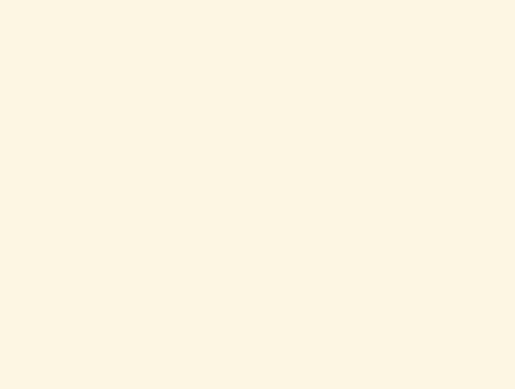

In [3]:
# Plot T1-weighted image
fig, ax = plt.subplots()
plotting.plot_anat(subj.t1w, cut_coords=(15, 5, 30), radiological=True, 
    axes=ax, colorbar=True)
ax.set_title('T1-Weighted Image')
plt.show()

# Load Monte Carlo distribution
Next, we load the results from our Monte Carlo distribution that modeled how to calculate MP2RAGE images if there were some Gaussian noise ($\sigma^2=0.005$) in the gradient echo readouts. This simulation ran for 100 million trials.

In [ ]:
# Load NumPy array for counts
counts = np.load(os.path.join(t1_mapping.definitions.SIMULATION_DATA, 'counts_100M_no_nan.npy'))
distr = np.load(os.path.join(t1_mapping.definitions.SIMULATION_DATA, 'distr_100M_no_nan.npy'))

## Calculate ideal MP2RAGE equations

In [ ]:
# Range of values for T1
delta_t1 = 0.05
t1_estimate = np.arange(0.05, 5.01, 0.05)
num_points = len(t1_estimate)

# Calculate what values would be produced using these parameters
GRE = t1_mapping.utils.gre_signal(T1=t1_estimate, **subj.eqn_params)

# Calculate what MP2RAGE image would have been
mp2rage1 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[1,:])
mp2rage2 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[2,:])

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5
 3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2
 4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9
 4.95 5.  ]


## Plot MP2RAGE equations

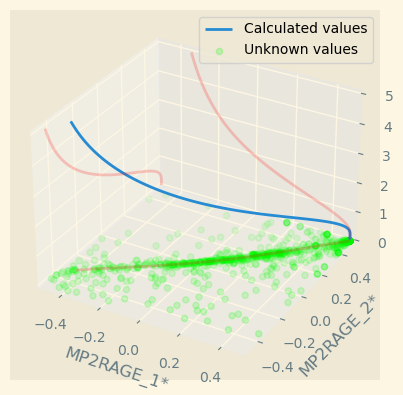

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot curve of known values
ax.plot(mp2rage1, mp2rage2, t1_estimate, label='Calculated values')
ax.set_xlabel('MP2RAGE_1*')
ax.set_ylabel('MP2RAGE_2*')
ax.set_zlabel('T1 (s)')
ax.set(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0,5))

# Plot values we want to calculate
t1w1 = subj.mp2rage[0]
t1w2 = subj.mp2rage[1]
indx = np.arange(0, len(t1w1.flatten()), 50000)
ax.scatter(t1w1.flatten()[indx], t1w2.flatten()[indx], zdir='z', color=[0,1,0,0.2], label='Unknown values')

# Plot projections
ax.plot(mp2rage1, mp2rage2, zs=0, zdir='z', color=[1,0,0,0.2])
ax.plot(mp2rage1, t1_estimate, zs=-0.5, zdir='x', color=[1,0,0,0.2])
ax.plot(mp2rage2, t1_estimate, zs=0.5, zdir='y', color=[1,0,0,0.2])

ax.legend()

# Calculate relative likelihood

In [1]:
# Likelihood for Gaussian model is given in distr - find max for each
max_L_gauss = np.max(distr, axis=2)
max_L_gauss_ind = np.argmax(distr, axis=2)
max_L_t1_vals = t1_estimate[max_L_gauss_ind]

# Likelihood for uniform model
# L_uni = np.full(distr.shape[0:1], 1/(distr.shape[0]*distr.shape[1]))
L_uni = np.sum(counts, axis=2)/np.sum(np.concatenate(counts))
L_uni = np.nan_to_num(L_uni, nan=0)

# Relative likelihood
# alpha = L_uni / (L_uni + max_L_gauss)
alpha = max_L_gauss/(max_L_gauss + L_uni)

# Plot alpha
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, alpha)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\alpha$')
ax.set_title(r'$\alpha$ Values')
plt.show

NameError: name 'np' is not defined

## Create LUT

Text(0.5, 0.92, 'LUT')

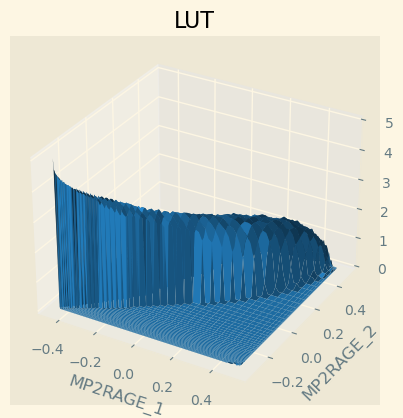

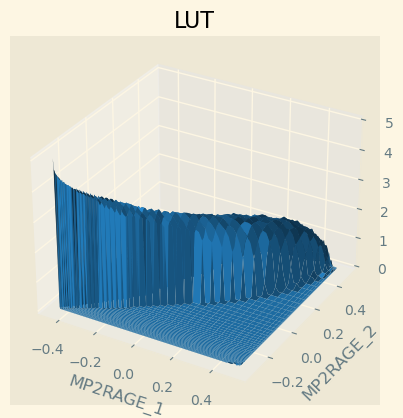

In [ ]:
t1_lut = max_L_t1_vals.copy()
T = 0.00025
t1_lut[alpha < T] = 0

# Plot LUT
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, t1_lut)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel('T1')
ax.set_title('LUT')


## Calculate T1 map

In [ ]:
t1

## Compare to Marques et al.

Text(0.5, 1.0, 'T1 Map (Marques et al.)')

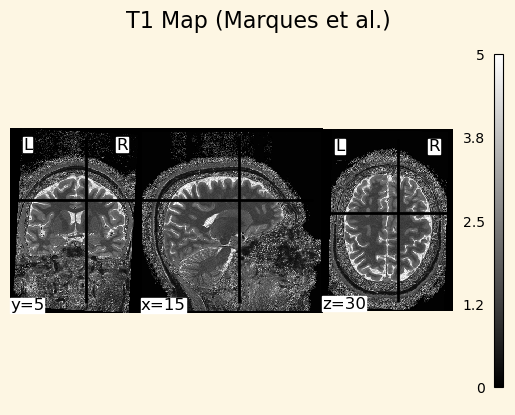

In [ ]:
# Plot T1 map from Marques repo
t1_marques = nib.load('/home/local/VANDERBILT/saundam1/Documents/MP2RAGE-related-scripts/example_t1map2.nii')
t1_marques_data = t1_marques.get_fdata()
fig, ax = plt.subplots()
plotting.plot_img(t1_marques, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True, vmin=0, vmax=5)
ax.set_title('T1 Map (Marques et al.)')

In [ ]:
# Plot difference image
t1_diff = t1_calc - t1_marques.get_fdata()
t1_diff_nifti = nib.nifti1.Nifti1Image(t1_diff, inv1_real.affine)
fig, ax = plt.subplots()
plotting.plot_img(t1_diff_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('Difference Image')

# Calculate RMSE
t_lin = t1_marques.get_fdata().flatten()
t_calc_lin = t1_calc.flatten()
RMSE = mean_squared_error(t_lin, t_calc_lin, squared=False)
print(f'{RMSE=}')

NameError: name 't1_calc' is not defined

## Save all NIFTIs

In [ ]:
# t1_calc_nifti.to_filename('outputs/example_t1_map.nii')
# t1_marques.to_filename('outputs/example_t1_map_marques.nii')
# t1_diff_nifti.to_filename('outputs/example_t1_map_diff.nii')